In [27]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
#import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
#import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
import tf_keras as keras  # Use tf_keras instead of tf.keras
from tf_keras import layers
from tf_keras.models import Model, Sequential
from tf_keras.layers import Input, Dropout, Dense
from tf_keras.optimizers import Adam
import tensorflow_probability as tfp
import tensorflow_probability.python.layers as tfpl
tfd = tfp.distributions
tfb = tfp.bijectors
from tf_keras.callbacks import CSVLogger

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

In [2]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [3]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    vals = [[] for _ in range(n_inputs)]


# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        for i in range(n_inputs):
            tmp = data.sel(x=lon, y=lat, band=i, method='nearest').values
            vals[i].append(tmp)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    for i in range(n_inputs):
        df[names[i]] = vals[i]
    
    return df


In [4]:
# Constants
n_inputs = 28
names = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12", "ndwi", "ndvi", "ndbi", 
        "B01 (pooled)", "B02 (pooled)", "B03 (pooled)", "B04 (pooled)", "B05 (pooled)", "B06 (pooled)", "B07 (pooled)", "B08 (pooled)", "B8A (pooled)", "B11 (pooled)", "B12 (pooled)", "ndwi (pooled)", "ndvi (pooled)", "ndbi (pooled)",
        "building_count_0-25ft", "building_impact_0-25ft", "building_count_25-50ft", "building_impact_25-50ft", "building_count_50-100ft", "building_impact_50-100ft", "building_count_100-200ft", "building_impact_100-200ft", "building_count_200-500ft", "building_impact_200-500ft",
        "tree_count_0-25ft", "tree_impact_0-25ft", "tree_count_25-50ft", "tree_impact_25-50ft", "tree_count_50-100ft", "tree_impact_50-100ft", "tree_count_100-200ft", "tree_impact_100-200ft", "tree_count_200-500ft", "tree_impact_200-500ft"]
UhiData_FileName = "Data/Training_data_uhi_index.csv"
satellite_data =  "Data/S2_median_fullBands_indeces.tiff"
tree_building_uhi_data = "Data/LATEST_combined_tree_building_uhi_features.csv"
test_size = 0.3

# Open the GeoTIFF file
tiff_path = "Data/S2_median_fullBands_indeces.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    cols = [src1.read(i) for i in range(1, n_inputs+1)]

In [5]:
# Would be faster in a df
feature_data = map_satellite_data(satellite_data, UhiData_FileName)

Mapping values: 100%|██████████| 11229/11229 [07:51<00:00, 23.82it/s]


In [6]:
# Redo columns
feature_data["ndwi"] = (feature_data["B03"] - feature_data["B08"])/(feature_data["B03"] + feature_data["B08"]) #Normalized Difference Water Index
feature_data["ndbi"] = (feature_data["B11"] - feature_data["B08"])/(feature_data["B11"] + feature_data["B08"]) # Normalized Difference Buildup Index
feature_data["ndvi"] = (feature_data["B08"] - feature_data["B04"])/(feature_data["B08"] + feature_data["B04"]) #Normalized Difference Vegetation Index
feature_data["ndwi (pooled)"] = (feature_data["B03 (pooled)"] - feature_data["B08 (pooled)"])/(feature_data["B03 (pooled)"] + feature_data["B08 (pooled)"]) #Normalized Difference Water Index
feature_data["ndbi (pooled)"] = (feature_data["B11 (pooled)"] - feature_data["B08 (pooled)"])/(feature_data["B11 (pooled)"] + feature_data["B08 (pooled)"]) # Normalized Difference Buildup Index
feature_data["ndvi (pooled)"] = (feature_data["B08 (pooled)"] - feature_data["B04 (pooled)"])/(feature_data["B08 (pooled)"] + feature_data["B04 (pooled)"]) #Normalized Difference Vegetation Index

feature_data['ndvi'] = feature_data['ndvi'].replace([np.inf, -np.inf], np.nan) 
feature_data['ndwi'] = feature_data['ndwi'].replace([np.inf, -np.inf], np.nan) 
feature_data['ndbi'] = feature_data['ndbi'].replace([np.inf, -np.inf], np.nan)
feature_data['ndvi (pooled)'] = feature_data['ndvi (pooled)'].replace([np.inf, -np.inf], np.nan) 
feature_data['ndwi (pooled)'] = feature_data['ndwi (pooled)'].replace([np.inf, -np.inf], np.nan) 
feature_data['ndbi (pooled)'] = feature_data['ndbi (pooled)'].replace([np.inf, -np.inf], np.nan) 

In [7]:
# Combining ground data and feature data into a single dataset.
ground_df = pd.read_csv(UhiData_FileName)
tree_building_df = pd.read_csv(tree_building_uhi_data)
uhi_data = combine_two_datasets(ground_df,feature_data)
uhi_data = combine_two_datasets(uhi_data, tree_building_df)

In [8]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['B01','B04','B06','B08','ndvi']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,...,tree_count_50-100ft,tree_impact_50-100ft,tree_count_100-200ft,tree_impact_100-200ft,tree_count_200-500ft,tree_impact_200-500ft,closest_tree_distance,closest_tree_dbh,longitude,latitude
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,841.5,841.5,1053.0,1155.0,1206.0,1481.5,...,2.0,25.845166,13.0,382.989385,51.0,694.608498,40.498933,5.0,-73.909167,40.813107
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,841.5,841.5,646.0,823.0,777.0,1130.5,...,4.0,71.716201,9.0,286.517317,53.0,731.532544,44.856958,7.0,-73.909215,40.812978
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,841.5,841.5,625.0,766.0,741.5,1130.5,...,2.0,51.704779,8.0,249.112379,52.0,671.714205,18.688324,7.0,-73.909242,40.812908
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,841.5,841.5,659.5,763.0,708.5,1077.5,...,1.0,10.949187,6.0,174.116477,52.0,723.484668,9.012552,7.0,-73.909257,40.812845
6,-73.909312,40.812710,24-07-2021 15:53,1.015143,841.5,841.5,551.5,768.5,659.0,1077.5,...,1.0,12.113698,3.0,32.561605,54.0,748.122336,35.179383,6.0,-73.909312,40.812710


In [9]:
# Load data, normalize distributions
model_data = uhi_data[names + ['UHI Index']]
md_data_std = model_data.apply(lambda x: (x - x.mean()) / x.std(), axis=0) 
md_data_std =md_data_std.apply(lambda x: pd.to_numeric(x, errors = 'coerce'), axis=0) 

In [10]:
# Divide data into training and testing
X = md_data_std.drop(columns=['UHI Index']).values
y = md_data_std['UHI Index'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=123)
print(X_train.shape) 
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5848, 48)
(5848, 2)
(2507, 48)
(2507, 2)


In [11]:
def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test).flatten()
    y_test_tmp = y_test[:,0].flatten()
    print(f"MSE: {mean_squared_error(y_test_tmp, y_pred)}")
    print(f"r2: {r2_score(y_test_tmp, y_pred)}")
    y_lazy_pred = np.mean(y_test_tmp) * np.ones(len(y_test_tmp))
    print(f"Lazy MSE: {mean_squared_error(y_test_tmp, y_lazy_pred)}")
    print(f"Lazy r2: {r2_score(y_test_tmp, y_lazy_pred)}")

In [68]:
# Standard Model
model1 = Sequential([
    Dense(64, activation = 'relu', input_shape=(48,) ),
    Dropout(0.1),
    Dense(64, activation = 'relu'),
    Dropout(0.1),
    Dense(64, activation = 'relu'),
    Dropout(0.1),
    Dense(1, activation = 'linear'),
])
model1.compile(optimizer=Adam(learning_rate=0.001) , loss = "MSE" )
log = CSVLogger(f"Model_Stats/standard_training.log", append=True)
model1.fit(X_train, y_train, epochs=100, validation_split=0.1, callbacks=[log])

Epoch 1/100
165/165 [==============================] - 2s 5ms/step - loss: 0.8438 - val_loss: 0.7522
Epoch 2/100
165/165 [==============================] - 0s 2ms/step - loss: 0.7282 - val_loss: 0.7019
Epoch 3/100
165/165 [==============================] - 0s 2ms/step - loss: 0.6910 - val_loss: 0.6688
Epoch 4/100
165/165 [==============================] - 0s 2ms/step - loss: 0.6513 - val_loss: 0.6514
Epoch 5/100
165/165 [==============================] - 0s 2ms/step - loss: 0.6236 - val_loss: 0.6114
Epoch 6/100
165/165 [==============================] - 0s 2ms/step - loss: 0.5890 - val_loss: 0.6068
Epoch 7/100
165/165 [==============================] - 0s 2ms/step - loss: 0.5626 - val_loss: 0.5813
Epoch 8/100
165/165 [==============================] - 0s 2ms/step - loss: 0.5481 - val_loss: 0.5769
Epoch 9/100
165/165 [==============================] - 0s 2ms/step - loss: 0.5400 - val_loss: 0.5499
Epoch 10/100
165/165 [==============================] - 0s 3ms/step - loss: 0.5314 - val_lo

79/79 [==============================] - 0s 1ms/step
MSE: 0.3604882896924598
r2: 0.6401260486184213
Lazy MSE: 1.0017070930211052
Lazy r2: 0.0


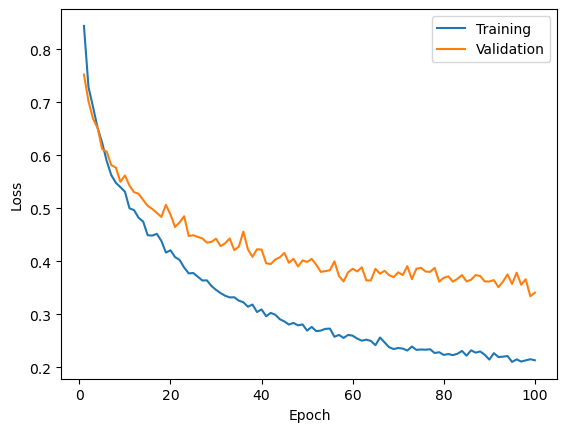

In [69]:
test_model(model1, X_test=X_test, y_test=y_test)
log = pd.read_csv(f"Model_Stats/standard_training.log")
training_loss = log["loss"]
validation_loss = log["val_loss"]
plt.plot(np.arange(1, len(training_loss) + 1), training_loss, label="Training")
plt.plot(np.arange(1, len(validation_loss) + 1), validation_loss, label="Validation")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [14]:
# Fixed prior: standard normal, wrapped in Independent
def prior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(loc=tf.zeros(n), scale=1.0),
                #tfd.Laplace(loc=tf.zeros(n), scale=1.0),
                #tfd.StudentT(df=3.0, loc=tf.zeros(n), scale=1.0),
                reinterpreted_batch_ndims=1)
        )
    ])

# Posterior: learnable multivariate Gaussian
def posterior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])

In [18]:
# Bayesian Model
inputs = Input(shape=(48,))
x = tfp.layers.DenseVariational(
    units=16,
    make_prior_fn=prior,
    make_posterior_fn=posterior,
    kl_weight = 1e-6,
    activation='sigmoid')(inputs)
outputs = Dense(1, activation='linear')(x)

model2 = Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer=Adam(0.001), loss="mse")
log = CSVLogger(f"Model_Stats/bnn_training.log", append=True)
model2.fit(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[log])

Epoch 1/50
165/165 [==============================] - 3s 10ms/step - loss: 1.2684 - val_loss: 1.2790
Epoch 2/50
165/165 [==============================] - 1s 8ms/step - loss: 1.1554 - val_loss: 1.1177
Epoch 3/50
165/165 [==============================] - 1s 8ms/step - loss: 1.0302 - val_loss: 1.0358
Epoch 4/50
165/165 [==============================] - 1s 7ms/step - loss: 0.9740 - val_loss: 1.0206
Epoch 5/50
165/165 [==============================] - 1s 8ms/step - loss: 0.9469 - val_loss: 0.9578
Epoch 6/50
165/165 [==============================] - 1s 8ms/step - loss: 0.9251 - val_loss: 0.9584
Epoch 7/50
165/165 [==============================] - 1s 8ms/step - loss: 0.9061 - val_loss: 0.9347
Epoch 8/50
165/165 [==============================] - 1s 7ms/step - loss: 0.9177 - val_loss: 0.9350
Epoch 9/50
165/165 [==============================] - 1s 8ms/step - loss: 0.9017 - val_loss: 0.9244
Epoch 10/50
165/165 [==============================] - 1s 7ms/step - loss: 0.8912 - val_loss: 0.909

79/79 [==============================] - 1s 3ms/step
MSE: 0.854667618409755
r2: 0.14678889231769887
Lazy MSE: 1.0017070930211052
Lazy r2: 0.0


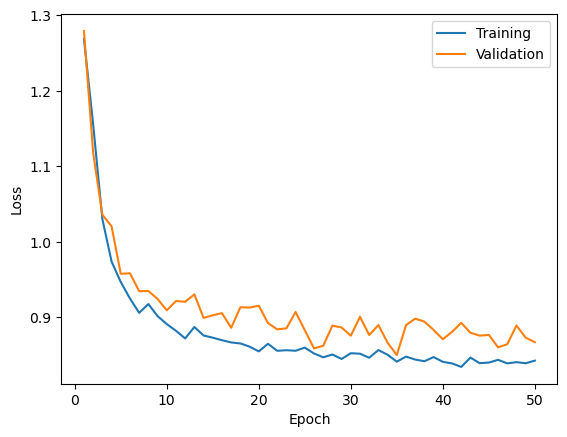

In [19]:
test_model(model2, X_test=X_test, y_test=y_test)
log = pd.read_csv(f"Model_Stats/bnn_training.log")
training_loss = log["loss"]
validation_loss = log["val_loss"]
plt.plot(np.arange(1, len(training_loss) + 1), training_loss, label="Training")
plt.plot(np.arange(1, len(validation_loss) + 1), validation_loss, label="Validation")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [105]:
# Prior function: Returns a callable that returns a Normal distribution with batch shape
def prior(kernel_size, bias_size=0, dtype=None):
    def prior_fn(shape): # 'shape' will be a TensorShape of (kernel_size + bias_size,)
        return tfd.Normal(loc=tf.zeros(shape, dtype=dtype), scale=1.0)
    return prior_fn

# Posterior function: Returns a callable that returns a Normal distribution with batch shape
def posterior(kernel_size, bias_size=0, dtype=None):
    def posterior_fn(shape): # 'shape' will be a TensorShape of (kernel_size + bias_size,)
        return tfd.Normal(
            loc=tf.Variable(lambda: tf.random.normal(shape, stddev=0.1, dtype=dtype)),
            scale=tf.math.softplus(tf.Variable(lambda: tf.random.normal(shape, stddev=0.1, dtype=dtype)))
        )
    return posterior_fn

# Define likelihood function (Gaussian)
def neg_log_likelihood(y_true, y_pred_dist):
    return -tf.reduce_mean(y_pred_dist.log_prob(y_true))

# Wrap output as a Normal distribution
def model_output_distribution(y_pred_mean):
    return tfd.Normal(loc=y_pred_mean, scale=1.0)

In [ ]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Probability version:", tfp.__version__)

# Build Bayesian Regression model with DenseVariational layers
inputs = Input(shape=(48,))

# First Dense Variational layer
x = tfpl.DenseVariational(
    units=16,
    make_prior_fn=prior,
    make_posterior_fn=posterior,
    kl_weight=1 / X_train.shape[0],
    activation='tanh'
)(inputs)

# Second Dense Variational layer for regression output
outputs = tfpl.DenseVariational(
    units=1,
    make_prior_fn=prior,
    make_posterior_fn=posterior,
    kl_weight=1 / X_train.shape[0]
)(x)

# Wrap the output of the second DenseVariational layer as a Normal distribution
distribution_output = tfpl.DistributionLambda(
    lambda t: tfd.Normal(loc=t, scale=1.0)
)(outputs)

# Final regression model
regression_model = Model(inputs=inputs, outputs=distribution_output)

# Compile the model
regression_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=neg_log_likelihood
)

# Train the model
log = CSVLogger(f"Model_Stats/regression_training.log", append=True)
regression_model.fit(X_train, y_train, epochs=20, validation_split=0.1, callbacks=[log])

TensorFlow version: 2.16.2
TensorFlow Probability version: 0.24.0


TypeError: Exception encountered when calling layer "dense_variational_51" (type DenseVariational).

<tf.Tensor 'Placeholder:0' shape=(None, 48) dtype=float32> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information.

<tf.Tensor 'Placeholder:0' shape=(None, 48) dtype=float32> was defined here:
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/runpy.py", line 86, in _run_code
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/asyncio/events.py", line 80, in _run
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code
    File "/var/folders/4g/j5ff47pj0j13qh3zpf6k4r8h0000gp/T/ipykernel_78024/3928534261.py", line 8, in <module>
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1050, in __call__
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 2577, in _functional_construction_call
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 2418, in _keras_tensor_symbolic_call
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 2459, in _infer_output_signature
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tensorflow/python/util/nest.py", line 628, in map_structure
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tensorflow/python/util/nest_util.py", line 1065, in map_structure
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tensorflow/python/util/nest_util.py", line 1105, in _tf_core_map_structure
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tensorflow/python/util/nest_util.py", line 1105, in <listcomp>
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tf_keras/src/engine/keras_tensor.py", line 660, in keras_tensor_to_placeholder
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tf_keras/src/engine/keras_tensor.py", line 243, in _to_placeholder
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tensorflow/python/util/nest.py", line 628, in map_structure
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tensorflow/python/util/nest_util.py", line 1065, in map_structure
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tensorflow/python/util/nest_util.py", line 1105, in _tf_core_map_structure
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tensorflow/python/util/nest_util.py", line 1105, in <listcomp>
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tf_keras/src/engine/keras_tensor.py", line 241, in component_to_placeholder
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tensorflow/python/ops/array_ops.py", line 2994, in placeholder
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tensorflow/python/ops/gen_array_ops.py", line 7073, in placeholder
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tensorflow/python/framework/op_def_library.py", line 796, in _apply_op_helper
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tensorflow/python/framework/func_graph.py", line 670, in _create_op_internal
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 2682, in _create_op_internal
    File "/Users/aji/anaconda3/envs/UHI/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 1177, in from_node_def

The tensor <tf.Tensor 'Placeholder:0' shape=(None, 48) dtype=float32> cannot be accessed from here, because it was defined in FuncGraph(name=dense_variational_51_scratch_graph, id=6155116480), which is out of scope.

Call arguments received by layer "dense_variational_51" (type DenseVariational):
  • inputs=tf.Tensor(shape=(None, 48), dtype=float32)

In [ ]:
test_model(regression_model, X_test=X_test, y_test=y_test)
log = pd.read_csv(f"Model_Stats/regression_training.log")
training_loss = log["loss"]
validation_loss = log["val_loss"]
plt.plot(np.arange(1, len(training_loss) + 1), training_loss, label="Training")
plt.plot(np.arange(1, len(validation_loss) + 1), validation_loss, label="Validation")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Predict distribution over outputs
pred_dist = regression_model(X_test)
pred_means = pred_dist.mean().numpy()
pred_stddevs = pred_dist.stddev().numpy()

num_samples = 1000

# Store predictions
predictions = []

for _ in range(num_samples):
    pred_dist = regression_model(X_test)    # This samples new weights each time
    sample = pred_dist.sample().numpy()    # Sample a value from the output distribution
    predictions.append(sample[0][0])       # Assuming scalar regression output

# Now predictions is a list of 1000 sampled outputs
predictions = np.array(predictions)

# You can now compute mean, std, percentiles, etc.
predictive_mean = np.mean(predictions)
predictive_std = np.std(predictions)

In [ ]:
# Gaussian Uncertainty Model
inputs = Input(shape=(48,))
x = Dense(64, activation='relu')(inputs)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)

# Predict mean and variance/standard deviation (split up)
mean = Dense(1, activation='linear')(x)
log_var = Dense(1, activation='linear')(x)
outputs = tf.keras.layers.concatenate([mean, log_var], name='outputs')  

# Define the model
model3 = Model(inputs=inputs, outputs=outputs)

# Defined unique loss function to fit the distribution
def gaussian_loss(y_true, y_pred):
    mean = y_pred[:, 0] 
    log_var = y_pred[:, 1]
    
    var = tf.exp(log_var)

    mse = tf.reduce_mean(tf.square(y_true - mean)) 

    kl_loss = tf.reduce_mean(0.5 * (tf.square(mean) + var - 1 - log_var))  

    return mse + kl_loss

model3.compile(optimizer=Adam(learning_rate=0.001), loss=gaussian_loss)
filename = f"Model_Stats/gaussian_uncertainty_training.log"
log = CSVLogger(filename, append=False)

model3.fit(
    X_train,
    y_train[:, 0],
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    callbacks=[log],
    shuffle=True,
    verbose=1
)

In [ ]:
def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    mean = y_pred[:, 0]
    log_var = y_pred[:, 1]
    
    y_test_tmp = y_test[:,0].flatten()  # Assuming y_test has shape (num_samples, 1)
    print(f"MSE: {mean_squared_error(y_test_tmp, mean)}") 
    print(f"r2: {r2_score(y_test_tmp, mean)}")
    
    y_lazy_pred = np.mean(y_test_tmp) * np.ones(len(y_test_tmp))
    print(f"Lazy MSE: {mean_squared_error(y_test_tmp, y_lazy_pred)}")
    print(f"Lazy r2: {r2_score(y_test_tmp, y_lazy_pred)}")
    
    loss = gaussian_loss(tf.convert_to_tensor(y_test[:,0], dtype=tf.float64), tf.convert_to_tensor(y_pred, dtype=tf.float64)).numpy()  
    print(f"Gaussian Loss: {loss}")

test_model(model3, X_test=X_test, y_test=y_test)
log = pd.read_csv(f"Model_Stats/gaussian_uncertainty_training.log")
training_loss = log["loss"]
validation_loss = log["val_loss"]
plt.plot(np.arange(1, len(training_loss) + 1), training_loss, label="Training")
plt.plot(np.arange(1, len(validation_loss) + 1), validation_loss, label="Validation")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()